pyroSAR internally uses a fixed naming scheme to keep track of processed results. For each scene an identifier is created, which contains the sensor, acquisition mode, orbit (ascending or descending) and the time stamp of the acquisition start. For example S1A__IW___A_20150222T170750, which is created by calling method outname_base():

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tifffile import tifffile
from PIL import Image
from pyroSAR import identify
import zipfile
from pyroSAR import identify
from pyroSAR.gamma import correctOSV
from pyroSAR.S1 import OSV
from pyroSAR.snap.auxil import parse_recipe, parse_node
from scipy import stats
from itertools import product
import os
import skimage as ski
import math

/home/regina/mambaforge/envs/hugging/lib/python3.12/site-packages/pyroSAR/gamma/api.py:31: UserWarning: could not find GAMMA installation directory; please set the GAMMA_HOME environment variable
  warnings.warn('could not find GAMMA installation directory; please set the GAMMA_HOME environment variable')


In [78]:
sigma = 5
N = np.linspace(0,1, 200)
#print(N)
rng = np.random.default_rng()                               # random  
noise = rng.standard_normal(100)
# print(noise)
#plt.hist(noise)
#plt.plot(N, noise)


In [83]:
quicklook_path = "./data/sar_data/quick-look.png"
# quicklook = "quick_look.png"

In [84]:
im_quicklook = Image.open(quicklook_path)

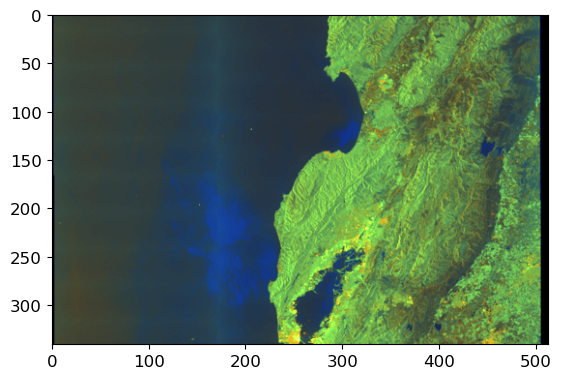

In [85]:
plt.imshow(im_quicklook)

In [49]:
# Image.MAX_IMAGE_PIXELS = None

https://pypi.org/project/tifffile/

https://stackoverflow.com/questions/7569553/working-with-tiffs-import-export-in-python-using-numpy

https://www.youtube.com/watch?v=0_BBRNYInx8

https://colab.research.google.com/drive/1NFxjNI-UIR7Ku0KERmv7Yb_586vHQW43?usp=sharing

https://github.com/johnowhitaker/aiaiart



or each attribute a fixed number of digits is reserved. In case the attribute is shorter than this number, the rest of the digits is filled with underscores. I.e., the sensor field is four digits long, but ‘S1A’ only three. Thus, S1A_ is the sensor slot. In the same way, IW__ is the acquisition mode slot, which is also four digits long. A denotes ascending orbit, the time stamp is in format YYYYmmddTHHMMSS.

Processing functions like geocode() add suffixes to this identifier to further keep track of individual processing steps performed on the dataset. This core concept is used by many pyroSAR functions internally to keep track of which scenes have been processed before.

In [7]:
# with zipfile.ZipFile('data/sentinel-1-data/S1A_IW_GRDH_1SDV_20240113T020752_20240113T020817_052082_064B71_F97A.zip', 'r') as zip_ref:
#    zip_ref.extractall('sar_data')

sar_path = 'data/sar_data/S1A_IW_GRDH_1SDV_20240113T020752_20240113T020817_052082_064B71_F97A.SAFE/measurement/'
filename = 's1a-iw-grd-vh-20240113t020752-20240113t020817-052082-064b71-002.tiff'
sarimage = sar_path + filename


In [112]:
#im = Image.open(sarimage)
#print(im.size)

#I = plt.imread(sarimage)
image = tifffile.imread(sarimage)
print(image.shape)


imarray = np.array(image)
print(imarray.shape)

(16696, 25771)
(16696, 25771)


In [10]:
#stats.describe(image)

In [11]:
#stats.describe(imarray)
#print(stats.describe(image))

In [12]:
pixel_values = image.flatten()
# plt.hist(pixel_values, bins = 256, range=(0, 255), alpha = 0.75, color='black');

In [ ]:
# plt.hist(np.log1p(pixel_values), bins = 256, alpha = 0.75, color='black');

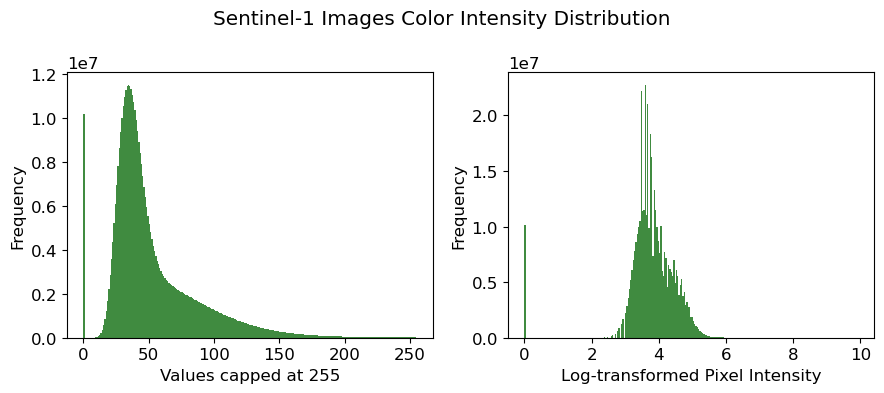

In [ ]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
fig.set_size_inches(9, 4)

pixel_values = image.flatten()
axs[0].hist(pixel_values, bins = 255, range=(0, 255), alpha = 0.75, color='darkgreen');

log_image = np.log1p(image)
pixel_values_log = log_image.flatten()
axs[1].hist(pixel_values_log, bins = 255, alpha=0.75, color= 'darkgreen');
# axs[0].title('Log-transformed Pixel Value Distribution')
axs[0].set_xlabel('Values capped at 255')
axs[1].set_xlabel('Log-transformed Pixel Intensity')

axs[0].set_ylabel('Frequency')
axs[1].set_ylabel('Frequency')

plt.suptitle('Sentinel-1 Images Color Intensity Distribution')

#plt.savefig('sar_pixel_distribution.png', dpi=300)

In [ ]:
print("Min: ", np.min(image))
print("Max: ", np.max(image))
print(type(im))
print("Mean: ", np.mean(image))
print("Median: ", np.median(image))
print("25th percentile: ", np.percentile(image, 25))
print("75th percentile: ", np.percentile(image, 75))

Min:  0
Max:  20105
<class 'PIL.TiffImagePlugin.TiffImageFile'>
Mean:  53.19752022982564
Median:  42.0
25th percentile:  32.0
75th percentile:  65.0


In [13]:
is_nan = np.isnan(image)
#print(is_nan)
has_nan = np.any(is_nan)
print(has_nan)

False


In [14]:
img_copy = image.copy()

In [15]:
A=np.abs(image)
Am=np.mean(A)
As=np.std(np.abs(A))

Alo, Ahi = np.percentile(A, [5,95])

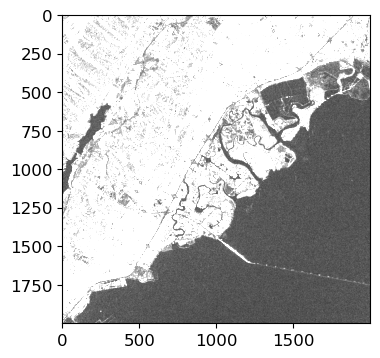

In [16]:
plt.figure(figsize=(4,4))
plt.imshow(np.abs(A[12500:14500, 12500:14500]),cmap='gray',vmin=0,vmax=Am+As)

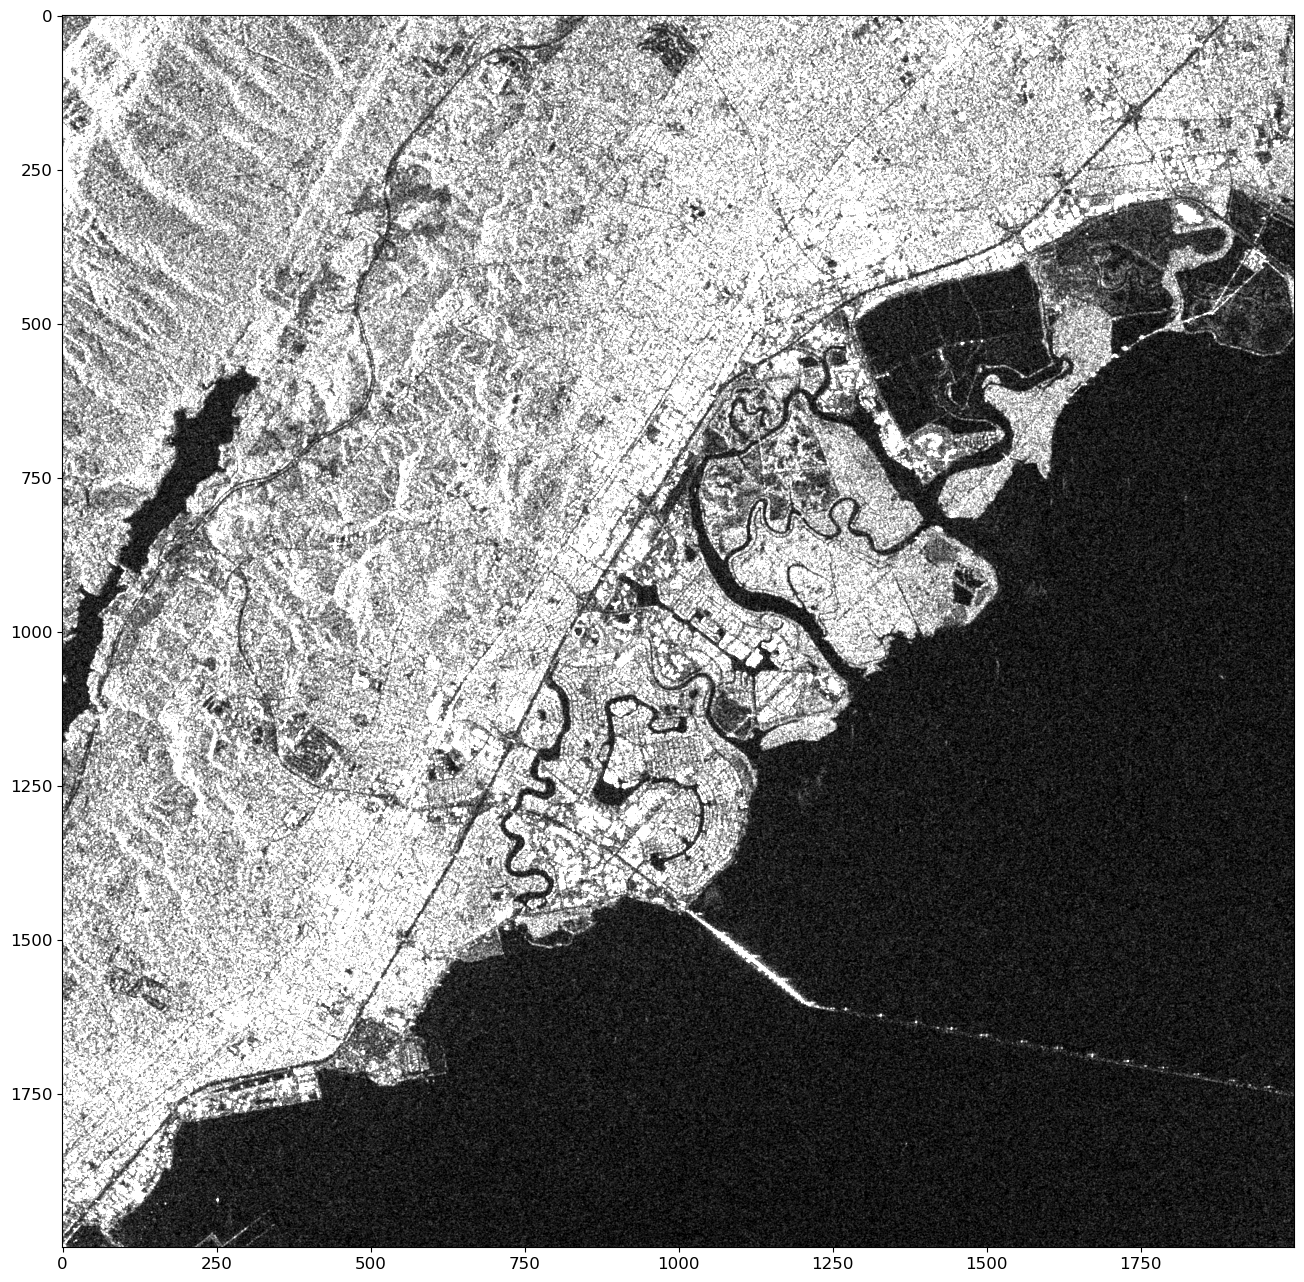

In [17]:
plt.figure(figsize=(16,16))
plt.imshow(np.abs(A[12500:14500, 12500:14500]),cmap='gray',vmin=Alo,vmax=Ahi)

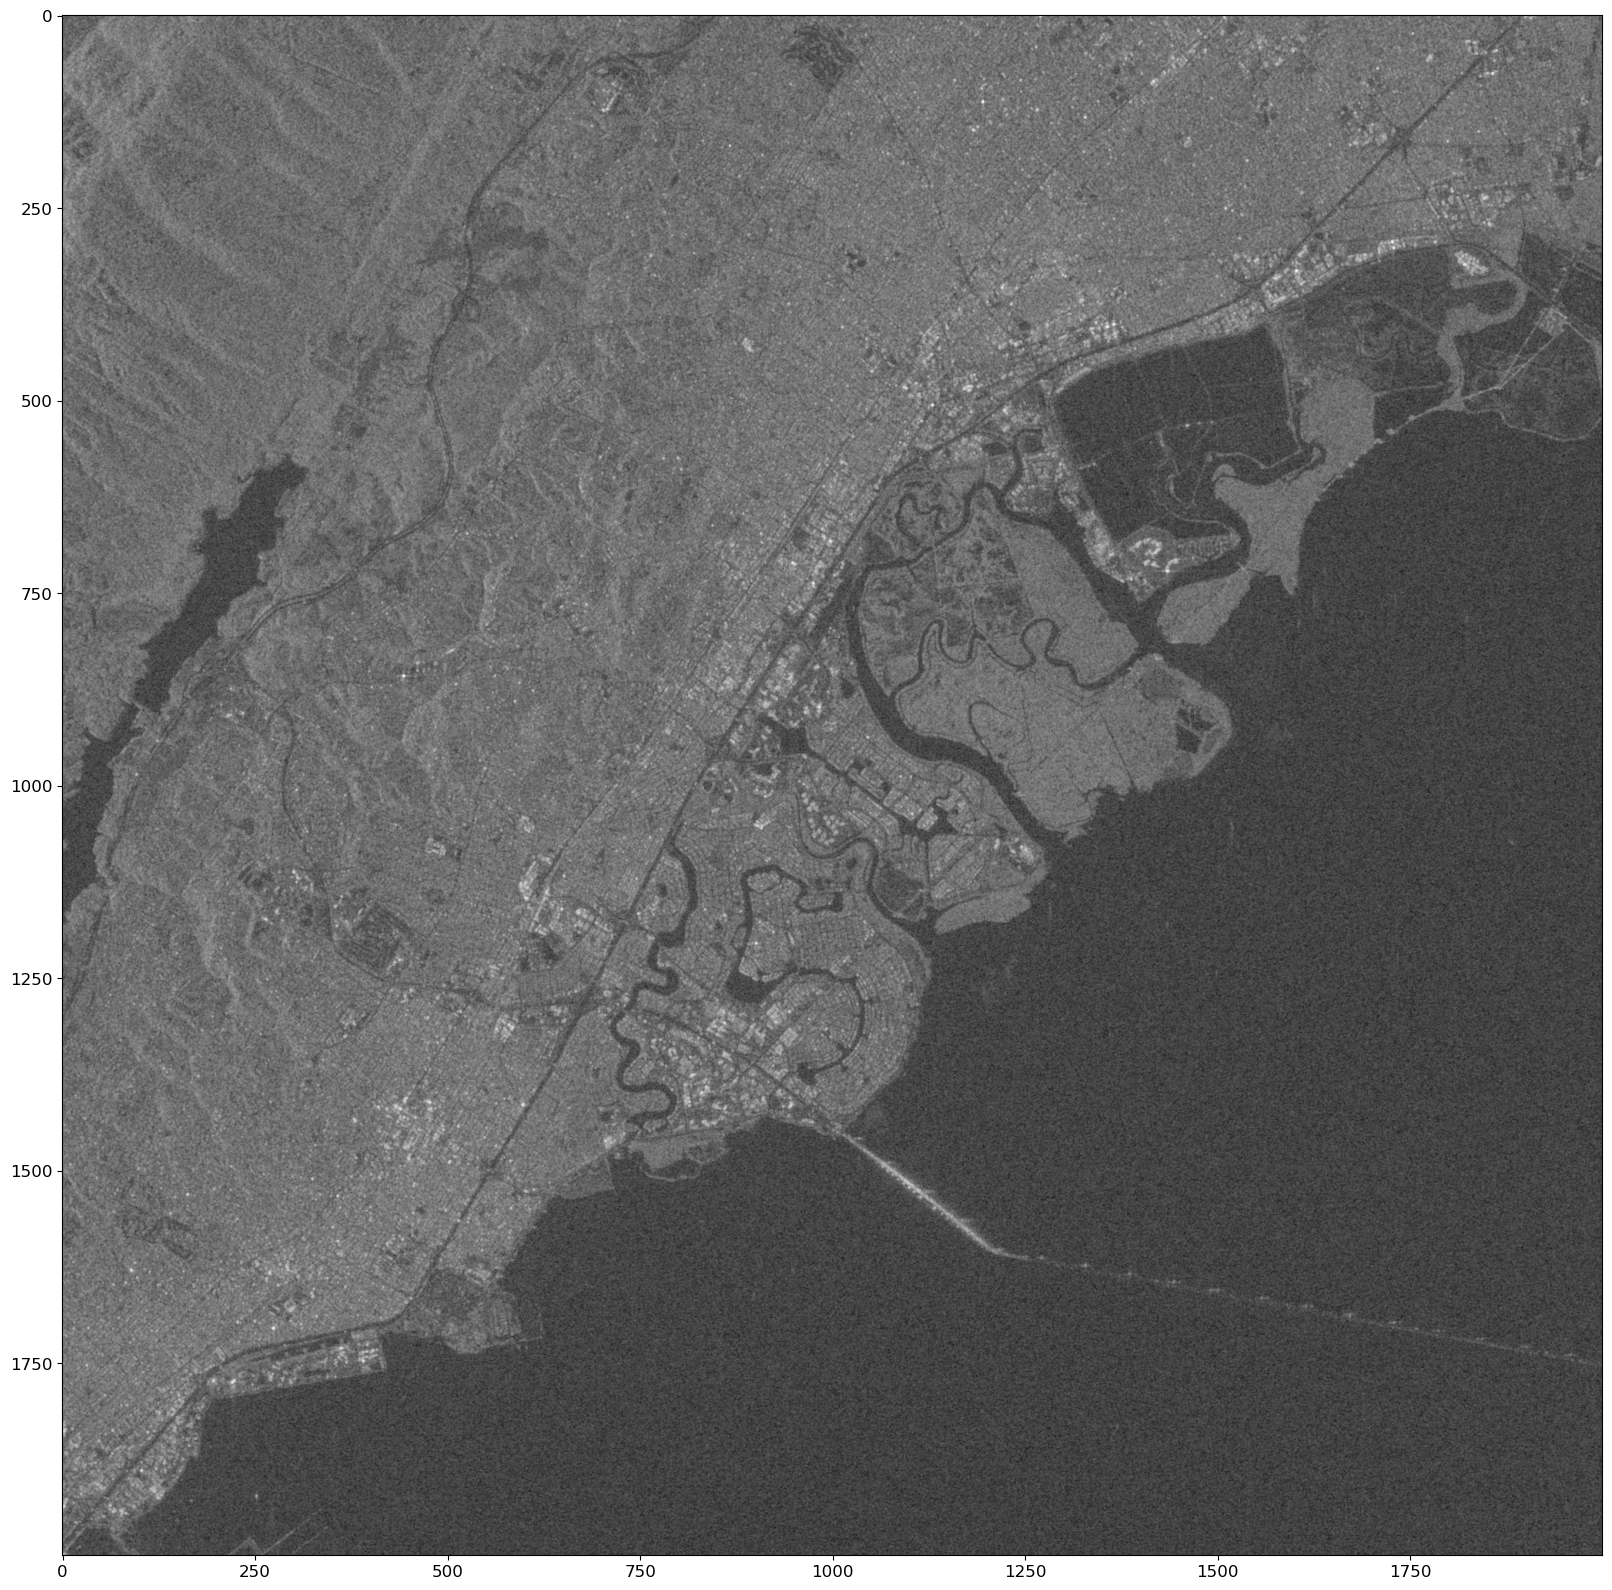

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(20*np.log10(np.abs(image[12500:14500, 12500:14500])),cmap='gray')

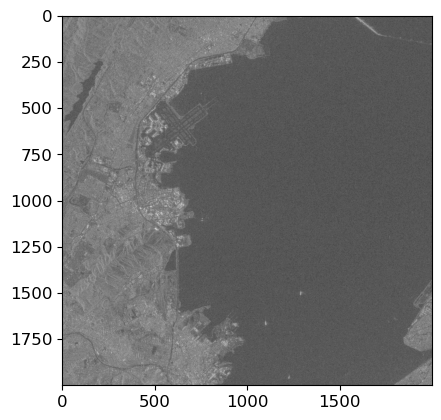

In [19]:
plt.imshow(20*np.log10(np.abs(image[14000:16000, 12000:14000])),cmap='gray')

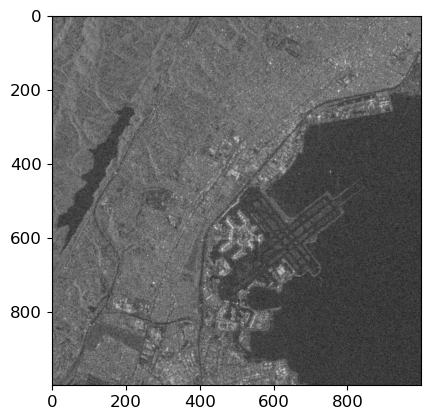

In [20]:
plt.imshow(20*np.log10(np.abs(image[14000:15000, 12000:13000])),cmap='gray')

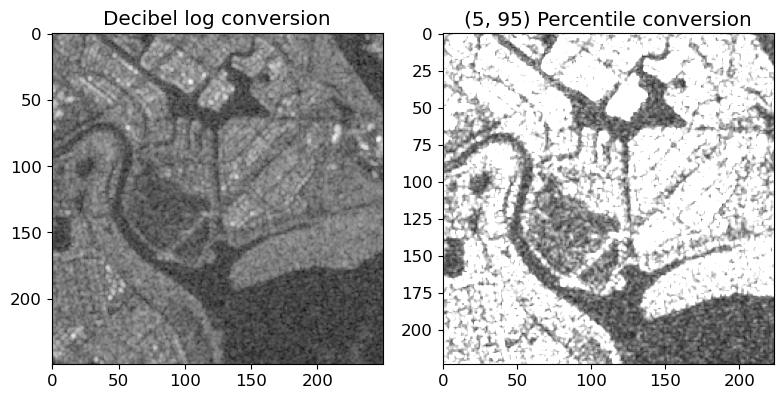

In [33]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(8, 5))
axs[0].imshow(20*np.log10(np.abs(image[13500:13750, 13500:13750])),cmap='gray')
axs[1].imshow(np.abs(A[13500:13724, 13500:13724]),cmap='gray',vmin=0,vmax=Am+As)
axs[0].set_title("Decibel log conversion")
axs[1].set_title("(5, 95) Percentile conversion")
plt.savefig('./data/images/sar_sample_image.png', dpi=300)

In [22]:
img = ski.exposure.rescale_intensity(image, in_range='image', out_range=(0,255)).astype(np.uint8)

In [114]:
arr_quick = np.array(im_quicklook)
print(arr_quick.shape)
print(imarray.shape)

(341, 513, 3)
(16696, 25771)


In [120]:
16696/2, 25771/3, 25771/3*2

(8348.0, 8590.333333333334, 17180.666666666668)

In [118]:
341/2, 513/3, 513/3*2

(170.5, 171.0, 342.0)

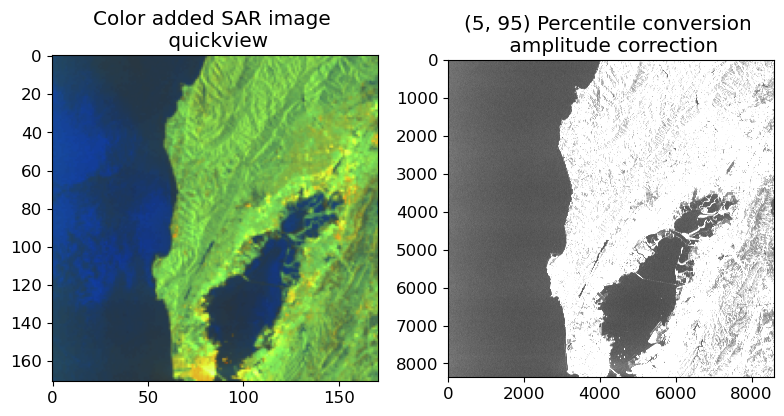

In [126]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(8, 5))
axs[0].imshow(arr_quick[170:341, 171:342,:], cmap='gray')
axs[1].imshow(np.abs(A[8348:16696, 8590:17181]),cmap='gray',vmin=0,vmax=Am+As)
    
axs[0].set_title("Color added SAR image \n quickview")
axs[1].set_title("(5, 95) Percentile conversion \n amplitude correction")
plt.savefig('./data/images/sar_sample_image2.png', dpi=300)


In [39]:
print(filename, sar_path)

s1a-iw-grd-vh-20240113t020752-20240113t020817-052082-064b71-002.tiff data/sar_data/S1A_IW_GRDH_1SDV_20240113T020752_20240113T020817_052082_064B71_F97A.SAFE/measurement/


In [50]:
def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    print(name, ext)
    print(w, h)
    # grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    # for i, j in grid:
    #     box = (j, i, j+d, i+d)
    #     out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
    #     img.crop(box).save(out)


In [51]:
tile(filename, sar_path, 'data/sar_data/tiles_256/', 256) 

s1a-iw-grd-vh-20240113t020752-20240113t020817-052082-064b71-002 .tiff
25771 16696


In [52]:
tilefile = 'data/sar_data/tiles/' + 's1a-iw-grd-vh-20240113t020752-20240113t020817-052082-064b71-002_0_19040.tiff'
tile = tifffile.imread(tilefile)
